In [103]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from enum import Enum
from pathlib import Path
import requests
import base64

In [2]:
class SegmentationClass(Enum):
    IVD = 0
    PE = 1
    TS = 2
    AAP = 3
    BACKGROUND = 4
    
def load_image(filename):
    mask =Image.open(filename)
    return np.asanyarray(mask)
    
def convertToCategoricalMasks(mask):
    # mask = np.asanyarray(mask)
    mask = np.copy(mask)
    unique_values = np.unique(mask)
    if len(unique_values) == 6 : # composit image class
        # print("HHHHHHHHHHHHHHHHHHHH")
        mask[mask==unique_values[0]] = unique_values[-1] #merging the background with unregistered class
        unique_values = np.unique(mask)

    for i in range(len(unique_values)):
        mask[mask == unique_values[i]] = i
    return mask

def getPEClassOnly(mask, structure_name = 'PE'):
    class_id = SegmentationClass[structure_name].value
    unique_values = np.unique(mask)
    # print(unique_values)
    # print(class_id)
    
    for i in range(len(unique_values)):
        if i == class_id:
            mask[mask == unique_values[i]] = 1
        else:
            mask[mask == unique_values[i]] = 0
    return mask
    

def show_binary_mask(image):
    plt.figure()
    plt.imshow(image)
    plt.show()
    
def show_image(title, image):
    plt.figure()
    # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if len(image.shape) == 3:  # Color image
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:  # Grayscale image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) 
        plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [87]:
def getIVDAndPEClass(temp_mask, structure_names = ['IVD', 'PE']):
    mask = temp_mask.copy()
    class_ids = []
    for struc_name in structure_names:
        class_id = SegmentationClass[struc_name].value
        class_ids.append(class_id)
    unique_values = np.unique(mask) 
    # Retain only classes 0, 1, and 4 (set others to 0)
    filtered_mask = np.where((mask == 0) | (mask == 1), mask, 4).astype(np.uint8)
    return filtered_mask
    
def getContours(segmentation_mask):
    labels_dict = {"IVD": 0,
                   "PE": 1,
                   # "BackGround":4
                  }
    contours_list = []
    # Find contours for the foreground regions
    for key, label in labels_dict.items():
        mask = (segmentation_mask == label).astype(np.uint8)*255
        # show_binary_mask(mask)
        # print(np.unique(mask))
        contours, _ = cv2.findContours(mask,  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # print(contours)
        contours_list.append(contours[0])
    # Assuming two main contours: circle-like and Y-shape
    if len(contours_list) < 2:
        show_image("less then two contours ", binary_mask)
        raise ValueError("Expected at least two contours for processing!")

    # Get bounding rectangles for all contours
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours_list]
    # Sort contours by the y-coordinate of their bounding rectangle (top-to-bottom)
    sorted_contours = sorted(zip(contours_list, bounding_boxes), key=lambda x: x[1][1])
    # Assign the contours based on the sorted order
    circle_contour, yshape_contour = sorted_contours[0][0], sorted_contours[1][0]
    return circle_contour, yshape_contour

def getTheUpperConvexPoint(defects, PE_contour):
    max_y = float('inf')
    filtered_lines = []
    highest_defect= {}
    if defects is not None:
        for i in range(defects.shape[0]):
            s, e, f, d = defects[i, 0]
            start = tuple(PE_contour[s][0])
            end = tuple(PE_contour[e][0])
            far = tuple(PE_contour[f][0])

            # Calculate the perpendicular distance of the farthest point to the line
            x1, y1 = start
            x2, y2 = end
            x3, y3 = far

            numerator = abs((x2 - x1) * (y1 - y3) - (x1 - x3) * (y2 - y1))
            denominator = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            distance = numerator / denominator if denominator != 0 else 0

            # Check if the distance is greater than 5 pixels (filtering criteria)
            if 5 <= distance:
                filtered_lines.append({
                    "start": start,
                    "end": end,
                    "far": far,
                    "distance": distance,
                    "depth": d,
                })

                # Check if the current farthest point is the highest (based on y-coordinate)
                if y1 < max_y:  # Compare based on y-coordinate
                    max_y = y1
                    highest_defect = {
                        "start_line": start,
                        "end_line": end,
                        "convex_point": far,
                        "distance": distance,
                        "depth": d,
                    }
    return highest_defect

def getIVDCenter(IVD_contour):
    moments = cv2.moments(IVD_contour)
    if moments["m00"] != 0:  # Avoid division by zero
        center_x = int(moments["m10"] / moments["m00"])
        center_y = int(moments["m01"] / moments["m00"])
    else:
        center_x, center_y = 0, 0  # Fallback values if the contour area is zero
    return (center_x, center_y)
    
def getConvexPointPE(PE_contour):
    PE_contour = np.array(PE_contour)
    hull = cv2.convexHull(PE_contour, returnPoints=False)
    defects = cv2.convexityDefects(PE_contour, hull)
    highest_defect = getTheUpperConvexPoint(defects, PE_contour)
    return highest_defect

def getFormenialLandMarks(IVD_contour, PE_contoure):
    bottom_IVD_contour = [pt for pt in IVD_contour if pt[0][1] >= IVD_contour[:, 0, 1].mean()]
    top_PE_contoure = [pt for pt in PE_contoure if pt[0][1] <= PE_contoure[:, 0, 1].mean()]
    
    IVD_middle_x = np.mean([pt[0][0] for pt in bottom_IVD_contour])
    PE_middle_x = np.mean([pt[0][0] for pt in top_PE_contoure])
    # Split each segment vertically into left and right halves
    left_bottom_IVD_contour = [pt for pt in bottom_IVD_contour if pt[0][0] < IVD_middle_x]
    rigt_bottom_IVD_contour = [pt for pt in bottom_IVD_contour if pt[0][0] >= IVD_middle_x]
    left_top_PE_contoure = [pt for pt in top_PE_contoure if pt[0][0] < PE_middle_x]
    right_top_PE_contoure = [pt for pt in top_PE_contoure if pt[0][0] >= PE_middle_x]
    
    formenial_distance_left, IVD_closest_point_left, PE_closest_point_left = find_min_distance(left_bottom_IVD_contour, left_top_PE_contoure)
    formenial_distance_right, IVD_closest_point_right, PE_closest_point_right = find_min_distance(rigt_bottom_IVD_contour, right_top_PE_contoure)
    
    fomenial_measurements_dict = {
        "left_formenial_dist" :formenial_distance_left,
        "left_formenial_IVD_point" : IVD_closest_point_left,
        "left_formenial_PE_point" : PE_closest_point_left ,
        "right_formenial_dist" :formenial_distance_right,
        "right_formenial_IVD_point" : IVD_closest_point_right,
        "right_formenial_PE_point" : PE_closest_point_right
    }
    return fomenial_measurements_dict

def find_min_distance(upper_points, lower_points):
    min_distance = float("inf")
    upper_closest_point = None
    lower_closest_point = None
    
    for pt1 in upper_points:
        for pt2 in lower_points:
            # print(pt2)
            dist = np.linalg.norm(np.array(pt1[0]) - np.array(pt2[0]))
            if dist < min_distance:
                min_distance = dist
                upper_closest_point = pt1[0]
                lower_closest_point = pt2[0]
    return min_distance, upper_closest_point, lower_closest_point

def lineEq(left_formenial_IVD_point, right_formenial_IVD_point):
    # Calculate the line coefficients a and b from two points, Tl and Tr, using a cross-product method
    # a = -m, b = 1 where slope m = (c2 - c1) / (r2 - r1)
    r1, c1 = left_formenial_IVD_point  # Line start (Tl)
    r2, c2 = right_formenial_IVD_point  # Line end (Tr)
    dr = r2 - r1
    dc = c2 - c1
    if dr == 0:
        a, b = 1, 0  # Vertical line
    else:
        m = dc / dr
        a, b = -m, 1
    # Calculate the perpendicular distance from IVD_lower_points to the line using the dot product
    # a * r + b * c + d = 0
    d = -(a * r1 + b * c1)
    return a, b, d

# def fetIVDLowerContour(IVD_lower_points):
    
def getqPoint(IVD_contour, formenial_land_marks, PE_convex_point, measurement_method = 'Natalia'): 
    # IVD_lower_points =  convert_contour_to_numpy(IVD_lower_points)
    bottom_IVD_contour = [pt for pt in IVD_contour if pt[0][1] >= IVD_contour[:, 0, 1].mean()]
    IVD_lower_points = np.array(bottom_IVD_contour).squeeze()
    left_formenial_IVD_point = formenial_land_marks['left_formenial_IVD_point'] 
    right_formenial_IVD_point = formenial_land_marks['right_formenial_IVD_point'] 
    if measurement_method == 'Natalia':
        # for IVD_point in IVD_lower_points:
        left_to_right_vec = left_formenial_IVD_point - right_formenial_IVD_point
        # print("IVD_lower", IVD_lower_points)        
        a, b, d = lineEq(left_formenial_IVD_point, right_formenial_IVD_point)
        # q_lr_dist = np.dot(IVD_lower_points, Tl_Tr_vec.T)
        q_left_to_right_dist = np.abs(np.dot(IVD_lower_points, np.array([a, b])) + d)       
        q_convex_dist = np.linalg.norm( PE_convex_point  - IVD_lower_points , axis=1)     
        q_dist_sub = q_left_to_right_dist - q_convex_dist    
        q_idx = np.argmax(q_dist_sub)  
        # print(bottom_IVD_contour[q_idx])
        # print(q_idx)
        # print(len(bottom_IVD_contour))
        
    return bottom_IVD_contour[q_idx][0]

def getIntersectioPoint(formenial_land_marks, IVD_center_point, PE_convex_point):
    left_formenial_IVD_point = formenial_land_marks["left_formenial_IVD_point"]
    right_formenial_IVD_point=  formenial_land_marks["right_formenial_IVD_point"]

    Tl_TR_line = line_equation(tuple(left_formenial_IVD_point), tuple(right_formenial_IVD_point))
    BM_DC_line = line_equation(IVD_center_point, PE_convex_point)
    # Find their intersection point
    intersection = find_intersection(Tl_TR_line, BM_DC_line)
    return intersection
def line_equation(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    if x1 == x2:  # Vertical line
        return None, x1  # slope is undefined; return x-intercept
    else:
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        return slope, intercept

def find_intersection(line1, line2):
    m1, c1 = line1
    m2, c2 = line2

    if m1 == m2:  # Parallel lines
        return None  # No intersection
    if m1 is None:  # Line1 is vertical
        x = c1
        y = m2 * x + c2
    elif m2 is None:  # Line2 is vertical
        x = c2
        y = m1 * x + c1
    else:
        x = (c2 - c1) / (m1 - m2)
        y = m1 * x + c1
    return int(x), int(y)

def detectHerniation(intrsc_point, q_point, PE_convex_point):
    # Convert lists to NumPy arrays
    intrsc_point = np.array(intrsc_point)
    q_point = np.array(q_point)
    PE_convex_point = np.array(PE_convex_point)
    
    dis_q = np.linalg.norm( PE_convex_point  - q_point)
    dis_intersc = np.linalg.norm( PE_convex_point  - intrsc_point)
    return dis_intersc >= dis_q, dis_q, dis_intersc

def getqPrjectioPoint(q, IVD_center, PE_convex ):
        # Convert to NumPy arrays if not already
    q, IVD_center, PE_convex = map(np.asarray, (q, IVD_center, PE_convex))
    # Vector calculations
    AB = PE_convex - IVD_center
    AP = q - IVD_center
    AB_norm_sq = np.dot(AB, AB)
    # Prevent division by zero for a degenerate segment
    if AB_norm_sq == 0:
        return A  # The segment reduces to a point
    # Projection scalar (t) to find P'
    t = np.dot(AP, AB) / AB_norm_sq
    # Projection onto the infinite line
    q_dash = IVD_center + t * AB
    # print(q_dash)
    return int(q_dash[0]), int(q_dash[1])
    
def drawImage(mask, formenial_land_marks, PE_convex_point, q_point, q_dash_point, IVD_center_point, intrsc_point, radius =2 ):
    
    left_formenial_IVD_point = formenial_land_marks["left_formenial_IVD_point"] 
    left_formenial_PE_point = formenial_land_marks["left_formenial_PE_point"]  
    right_formenial_IVD_point = formenial_land_marks["right_formenial_IVD_point"] 
    right_formenial_PE_point = formenial_land_marks["right_formenial_PE_point"] 

    # Using high-contrast colors for different elements
    cv2.line(mask, tuple(left_formenial_IVD_point), tuple(right_formenial_IVD_point), (255, 255, 0), radius-1)  # Cyan
    cv2.line(mask, tuple(PE_convex_point), tuple(IVD_center_point), (255, 0, 255), radius-1)  # Magenta

    cv2.line(mask, tuple(left_formenial_IVD_point), tuple(left_formenial_PE_point), (255, 140,0 ), radius)  # Orange
    cv2.line(mask, tuple(right_formenial_IVD_point), tuple(right_formenial_PE_point), (255, 140,0 ), radius)  # Orange

    # Points with strong contrast
    cv2.circle(mask, tuple(PE_convex_point), radius, (0, 255, 0), -1)  # Green
    cv2.circle(mask, tuple(q_point), radius, (0, 0, 255), -1)  # Red
    cv2.circle(mask, tuple(q_dash_point), radius, (255, 0, 255), -1)  # Magenta
    cv2.circle(mask, tuple(IVD_center_point), radius, (0, 255, 255), -1)  # Yellow
    cv2.circle(mask, tuple(intrsc_point), radius, (255, 255, 255), -1)  # White

    # Foraminal landmarks in bright blue
    cv2.circle(mask, tuple(left_formenial_IVD_point), radius, (255, 0, 0), -1)  # Blue
    cv2.circle(mask, tuple(left_formenial_PE_point), radius, (255, 0, 0), -1)  # Blue
    cv2.circle(mask, tuple(right_formenial_IVD_point), radius, (255, 0, 0), -1)  # Blue
    cv2.circle(mask, tuple(right_formenial_PE_point), radius, (255, 0, 0), -1)  # Blue

def showMaskAndMeasurements(binary_mask, measurements_x_mask):
    # Plot using Matplotlib
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the original mask
    axes[0].imshow(binary_mask)
    axes[0].set_title("Original Mask")
    axes[0].axis("off")

    # Display the measurements on the mask
    axes[1].imshow(measurements_x_mask)
    axes[1].set_title("Measurements Overlay")
    axes[1].axis("off")    

def showMaskAndMeasurementsAndInfo(binary_mask,measurements_x_mask, info):
    # Plot using Matplotlib
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the original mask
    axes[0].imshow(binary_mask)
    axes[0].set_title("Original Mask")
    axes[0].axis("off")

    # Display the measurements on the mask
    axes[1].imshow(measurements_x_mask)
    axes[1].set_title("Measurements Overlay")
    axes[1].axis("off")  
    # Text to display on the measurement plot
    info_text = (
        f"Disc Herniation: {info['disc_herniation']}\n"
        f"Dis_Q: {info['dis_q']:.2f} px\n"
        f"Dis_Intersc: {info['dis_intersc']:.2f} px\n"
        f"Left Formenial Dist: {info['left_formenial_dist']:.2f} mm\n"
        f"Right Formenial Dist: {info['right_formenial_dist']:.2f} mm\n"
        f"image_name: {info['image_name']} "

    )

    # Add the text to the plot
    axes[1].text(
        0.95, 0.05, info_text,
        fontsize=10, color="white", ha="right", va="bottom",
        bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'),
        transform=axes[1].transAxes
    )
    # Show the plot
    plt.tight_layout()
    plt.show()

def preprocessMask(binary_mask):
    # Apply morphological erosion to disconnect nearby regions
    kernel = np.ones((2, 2), np.uint8)  # Adjust kernel size as needed
    eroded_mask = cv2.erode(binary_mask, kernel, iterations=1)
    return eroded_mask

def getMeasurementsInfo(disc_herniation, dis_q, dis_intersc, left_formenial_dist, right_formenial_dist,  herniation_ratio, pix_spacing, image_name):
     return  {
        'disc_herniation': round(disc_herniation * pix_spacing,3),
        'dis_q': round(dis_q * pix_spacing,3),
        'dis_intersc': round(dis_intersc * pix_spacing,3),
        'left_formenial_dist': round(left_formenial_dist * pix_spacing,3),
        'right_formenial_dist': round(right_formenial_dist * pix_spacing,3),
        'herniation_ratio':round(herniation_ratio,3),
         'image_name': image_name
    }

def getHerniationRatio(PE_convex_point, intersc_point, q_dash_point):
    intersc_point = np.array(intersc_point)
    q_point = np.array(q_dash_point)
    PE_convex_point = np.array(PE_convex_point)
    
    dist_q_dash = np.linalg.norm( PE_convex_point  - q_dash_point)
    dist_p = np.linalg.norm( PE_convex_point  - intersc_point)
    ratio = dist_q_dash/dist_p
    return ratio

#### Get all land marks

In [95]:
def applyAxialMeasurements(image_name_path, mask_name_path, pix_spacing=0.6875):
    try:
        image_name = os.path.basename(image_name_path).split('.')[0]
        # Process the image and mask
        mask = load_image(mask_name_path)
        image = load_image(image_name_path)
        
        # Process combined PE and IVD
        mask_IVD_PE = convertToCategoricalMasks(mask)
        IVD_and_PE_mask = getIVDAndPEClass(mask_IVD_PE)
        binary_mask = np.where((IVD_and_PE_mask == 0) | (IVD_and_PE_mask == 1), 255, 0).astype(np.uint8)
        
        # Get contours for PE and IVD
        IVD_contour, PE_contour = getContours(IVD_and_PE_mask)
        binary_mask = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
        
        # Get landmarks and measurements
        PE_highest_defect_dict = getConvexPointPE(PE_contour)
        PE_convex_point = PE_highest_defect_dict['convex_point']
        formenial_land_marks = getFormenialLandMarks(IVD_contour, PE_contour)
        q_point = getqPoint(IVD_contour, formenial_land_marks, PE_convex_point, measurement_method='Natalia')
        IVD_center_point = getIVDCenter(IVD_contour)
        intrsc_point = getIntersectioPoint(formenial_land_marks, IVD_center_point, PE_convex_point)
        q_dash_point = getqPrjectioPoint(q_point, IVD_center_point, PE_convex_point)
        disc_herniation, dis_q, dis_intersc = detectHerniation(intrsc_point, q_point, PE_convex_point)
        herniation_ratio = getHerniationRatio(PE_convex_point, intrsc_point, q_dash_point)    
        r_ratio = np.linalg.norm(np.array(q_dash_point) - np.array(PE_convex_point)) / dis_intersc
        # Add text overlay to the measurements subplot
        info = getMeasurementsInfo(disc_herniation, dis_q, dis_intersc, formenial_land_marks['left_formenial_dist'],
                       formenial_land_marks['right_formenial_dist'], herniation_ratio, pix_spacing, image_name)
        
        measurements_x_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        drawImage(measurements_x_image, formenial_land_marks, PE_convex_point, q_point, q_dash_point, IVD_center_point, intrsc_point)
        return info, measurements_x_image
    except Exception as e:
        print(f"Skipping {image_name}: {e}")
        


#### Draw specific land marks

In [96]:
idx = 500
masks_dir = '../Datasets/Ground_Truth_Label/04_Intermediary_Ground_Truth_Data/Label_Images/'
images_dir = '../Datasets/Ground_Truth_Label/04_Intermediary_Ground_Truth_Data/T1_Output//'
images_list = [os.path.join(images_dir, img_name)  for img_name in os.listdir(images_dir)]
masks_list = [os.path.join(masks_dir, mask_name)  for mask_name in os.listdir(masks_dir)]
image_name_path =images_list[idx]
mask_name_path =masks_list[idx]
print(image_name_path)
print(mask_name_path)

../Datasets/Ground_Truth_Label/04_Intermediary_Ground_Truth_Data/T1_Output//T1_0183_D5.png
../Datasets/Ground_Truth_Label/04_Intermediary_Ground_Truth_Data/Label_Images/L1_0183_D5.png


{'disc_herniation': 0.688, 'dis_q': 14.438, 'dis_intersc': 15.827, 'left_formenial_dist': 4.812, 'right_formenial_dist': 4.612, 'herniation_ratio': 0.913, 'image_name': 'T1_0183_D5'}


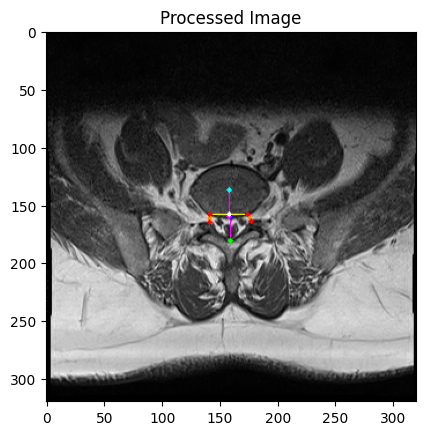

In [97]:
info, image_overlayed = applyAxialMeasurements(image_name_path, mask_name_path)
print(info)
# Display the processed image
plt.imshow(image_overlayed)  # Show the image
plt.title("Processed Image")  # Set the title
plt.show()  # Display the image

###### Testing API endpoint

{'disc_herniation': 0.688, 'dis_q': 14.438, 'dis_intersc': 15.827, 'left_formenial_dist': 4.812, 'right_formenial_dist': 4.612, 'herniation_ratio': 0.913, 'image_name': 'dummy'}


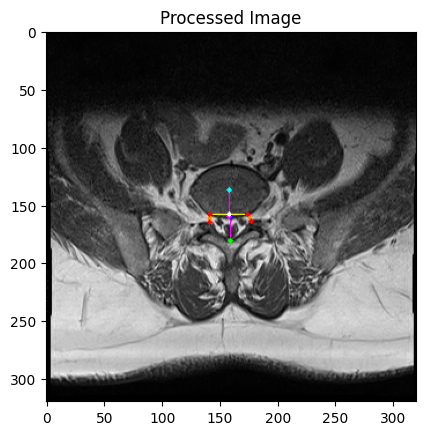

In [106]:
url = "http://127.0.0.1:8000/axial_measurements/"
data = {
    "pixel_spacing": 0.6875  # Modify as needed
}
files = {
    "image_file": open(image_name_path, "rb"), 
    "mask_file": open(mask_name_path, "rb"),
}
response = requests.post(url,  files=files, data=data)
response_data = response.json()

# Decode Base64 image
image_base64 = response_data["image"]
image_bytes = base64.b64decode(image_base64)
image_array = np.frombuffer(image_bytes, dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
print(response_data["measurements"])
# Display the processed image
plt.imshow(image)  # Show the image
plt.title("Processed Image")  # Set the title
plt.show()  # Display the image